# Modeling and Evaluation

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve
)

In [17]:
DATA_FEAT = Path('../data/features')
MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

In [18]:
df = pd.read_parquet(DATA_FEAT / 'url_features_complete.parquet')

In [20]:
RANDOM_STATE = 42 # funny
np.random.seed(RANDOM_STATE)

In [21]:
with open(DATA_FEAT / 'feature_metadata.json', 'r') as f:
    feature_info = json.load(f)

In [22]:
df.shape, feature_info['top_15_features']

((641119, 46),
 ['num_params',
  'path_depth',
  'special_char_ratio',
  'file_extension_count',
  'query_length',
  'special_char_count',
  'vowel_consonant_ratio',
  'subdomain_count',
  'contains_date_pattern',
  'url_length_safe',
  'url_length',
  'entropy',
  'has_ip',
  'word_count',
  'contains_version_pattern'])

Modeling prep and train-test split with stratification

In [23]:
numeric_features = df.select_dtypes(include=[np.number])

In [24]:
feature_columns = [col for col in numeric_features.columns if col not in ['label']]

In [25]:
X = numeric_features[feature_columns]
y = df['label']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

In [30]:
y_train.value_counts(normalize=True).sort_index()

label
0    0.667708
1    0.146753
2    0.036881
3    0.148658
Name: proportion, dtype: float64

In [31]:
y_test.value_counts(normalize=True).sort_index()

label
0    0.667707
1    0.146751
2    0.036881
3    0.148662
Name: proportion, dtype: float64

# Random Forest Model

Chosen RF as it seems to be great for this type of problem in particular
- handles mixed feature types
- feature importance within
- some sort of 'resistance' to overfitting
- works well with categorical encoded features
- no need for feature scaling

In [32]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,   # Require minimum samples for splits
    min_samples_leaf=5,
    max_features='sqrt',    # Use subset of features per tree
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)

In [33]:
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

# XGBoost

XGBoost also suited here and is a very efficient model which is useful due to hardware limits
- performs well with tabular data
- built in 'regularisation' helps prevent overfitting
- handles missing values well
- gradient boosting implemented
- good with imbalanced datasets

In [35]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,          # L1 regularisation
    reg_lambda=0.1,         # L2 regularisation
    random_state=RANDOM_STATE,
    eval_metric='mlogloss',  # Multi-class log loss
    n_jobs=-1,
    use_label_encoder=False
)


In [37]:
xgb_model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [38]:
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)

# Model Performance Comparison

In [39]:
models = {
    'Random Forest': (rf_pred, rf_pred_proba, rf_model),
    'XGBoost': (xgb_pred, xgb_pred_proba, xgb_model)
}

In [40]:
results = {}

In [41]:
for model_name, (pred, pred_proba, model) in models.items():
    # Basic metrics
    accuracy = accuracy_score(y_test, pred)
    f1_macro = f1_score(y_test, pred, average='macro')
    f1_weighted = f1_score(y_test, pred, average='weighted')
    
    # Multi-class ROC-AUC (one-vs-rest)
    try:
        roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr', average='macro')
    except:
        roc_auc = None
    
    results[model_name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc
    }

In [42]:
results_df = pd.DataFrame(results).T
results_df.round(4)

,accuracy,f1_macro,f1_weighted,roc_auc
Random Forest,0.9403,0.9213,0.9416,0.9905
XGBoost,0.9634,0.9442,0.9627,0.9939


In [43]:
best_model_name = results_df['f1_weighted'].idxmax()
best_model = models[best_model_name][2]
best_pred = models[best_model_name][0]

In [45]:
best_model_name

'XGBoost'

In [47]:
print(f"F1-weighted score: {results_df.loc[best_model_name, 'f1_weighted']:.4f}")

F1-weighted score: 0.9627


In [50]:
class_names = ['Benign', 'Phishing', 'Malware', 'Defacement']
print(classification_report(y_test, best_pred, target_names=class_names))

              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98     85616
    Phishing       0.91      0.84      0.88     18817
     Malware       0.98      0.90      0.94      4729
  Defacement       0.97      0.99      0.98     19062

    accuracy                           0.96    128224
   macro avg       0.96      0.93      0.94    128224
weighted avg       0.96      0.96      0.96    128224



# Confusion Matrix

In [51]:
cm = confusion_matrix(y_test, best_pred)

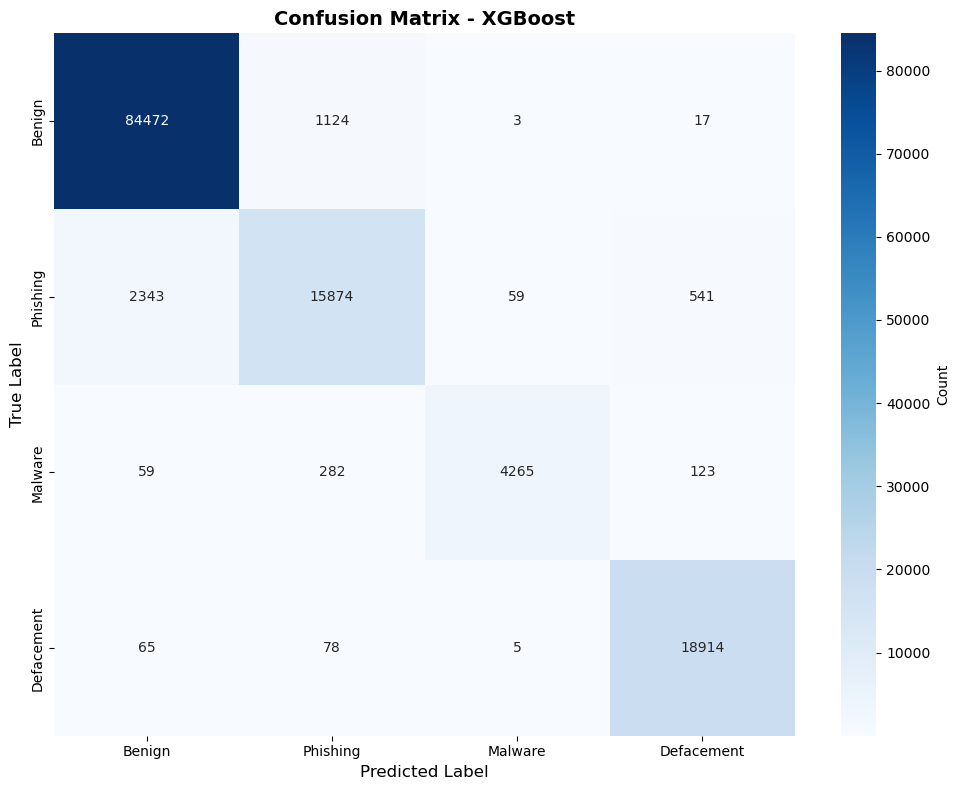

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})

plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [55]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
    print(f"{class_name} accuracy: {acc:.3f}")

Benign accuracy: 0.987
Phishing accuracy: 0.844
Malware accuracy: 0.902
Defacement accuracy: 0.992


# Feature Importance

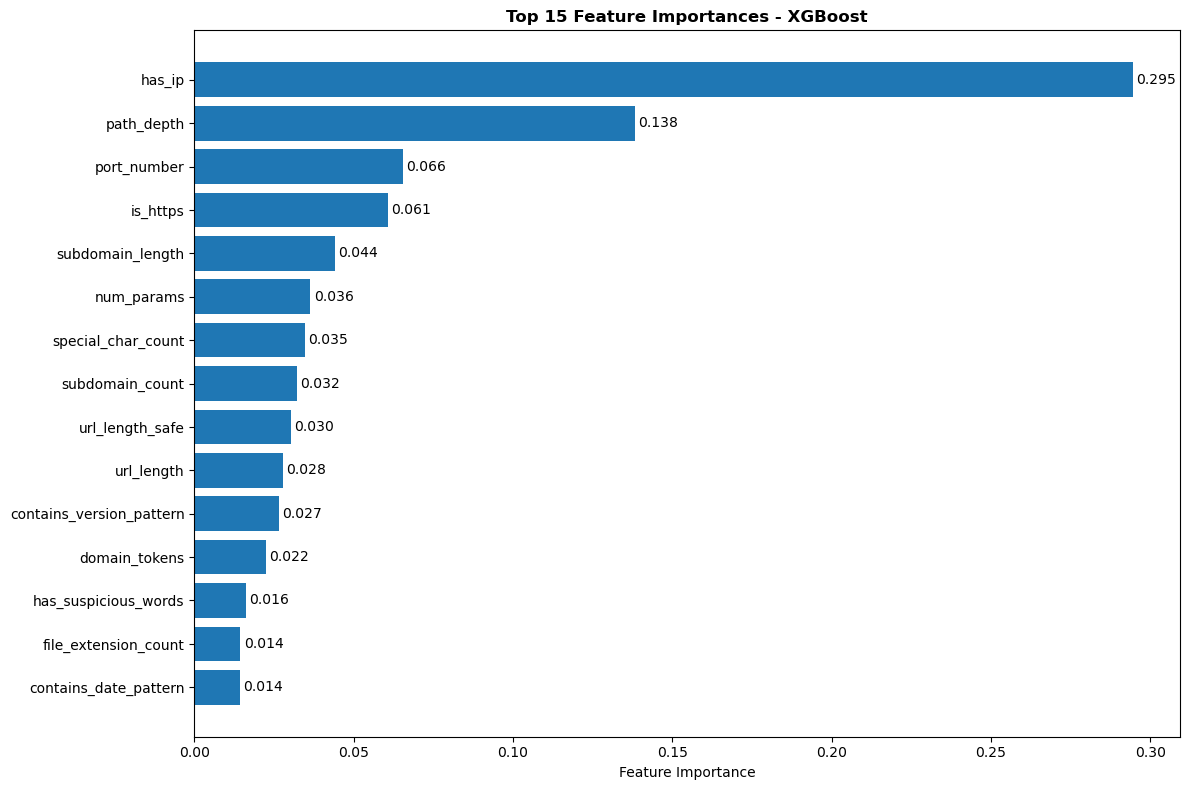

Top 10 Most Important Features:
 1. has_ip                   : 0.2946
 2. path_depth               : 0.1382
 3. port_number              : 0.0656
 4. is_https                 : 0.0606
 5. subdomain_length         : 0.0440
 6. num_params               : 0.0364
 7. special_char_count       : 0.0346
 8. subdomain_count          : 0.0321
 9. url_length_safe          : 0.0302
10. url_length               : 0.0279


In [56]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X.columns
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 most important features
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    bars = plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:25s}: {row['importance']:.4f}")

# Cross-Validation analysis

In [57]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [58]:
cv_results = {}

In [60]:
# using smaller sample for CV to speed up evaluation due to performance issues
# CV is primarily for model comparison only
sample_size = min(50000, len(X_train))
cv_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_cv = X_train.iloc[cv_indices]
y_cv = y_train.iloc[cv_indices]

In [61]:
for model_name, (_, _, model) in models.items():
    # Single metric CV for speed - use most important metric
    f1_weighted_scores = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='f1_weighted', n_jobs=-1)
    
    cv_results[model_name] = {
        'f1_weighted': (f1_weighted_scores.mean(), f1_weighted_scores.std()),
        'cv_samples': len(X_cv)
    }

Cross-validating Random Forest...
Cross-validating XGBoost...


In [62]:
for model_name, metrics in cv_results.items():
    mean, std = metrics['f1_weighted']
    print(f"{model_name:15s}: {mean:.4f} (±{std*2:.4f})")

Random Forest  : 0.9343 (±0.0040)
XGBoost        : 0.9543 (±0.0034)


# Model comparison visualisation

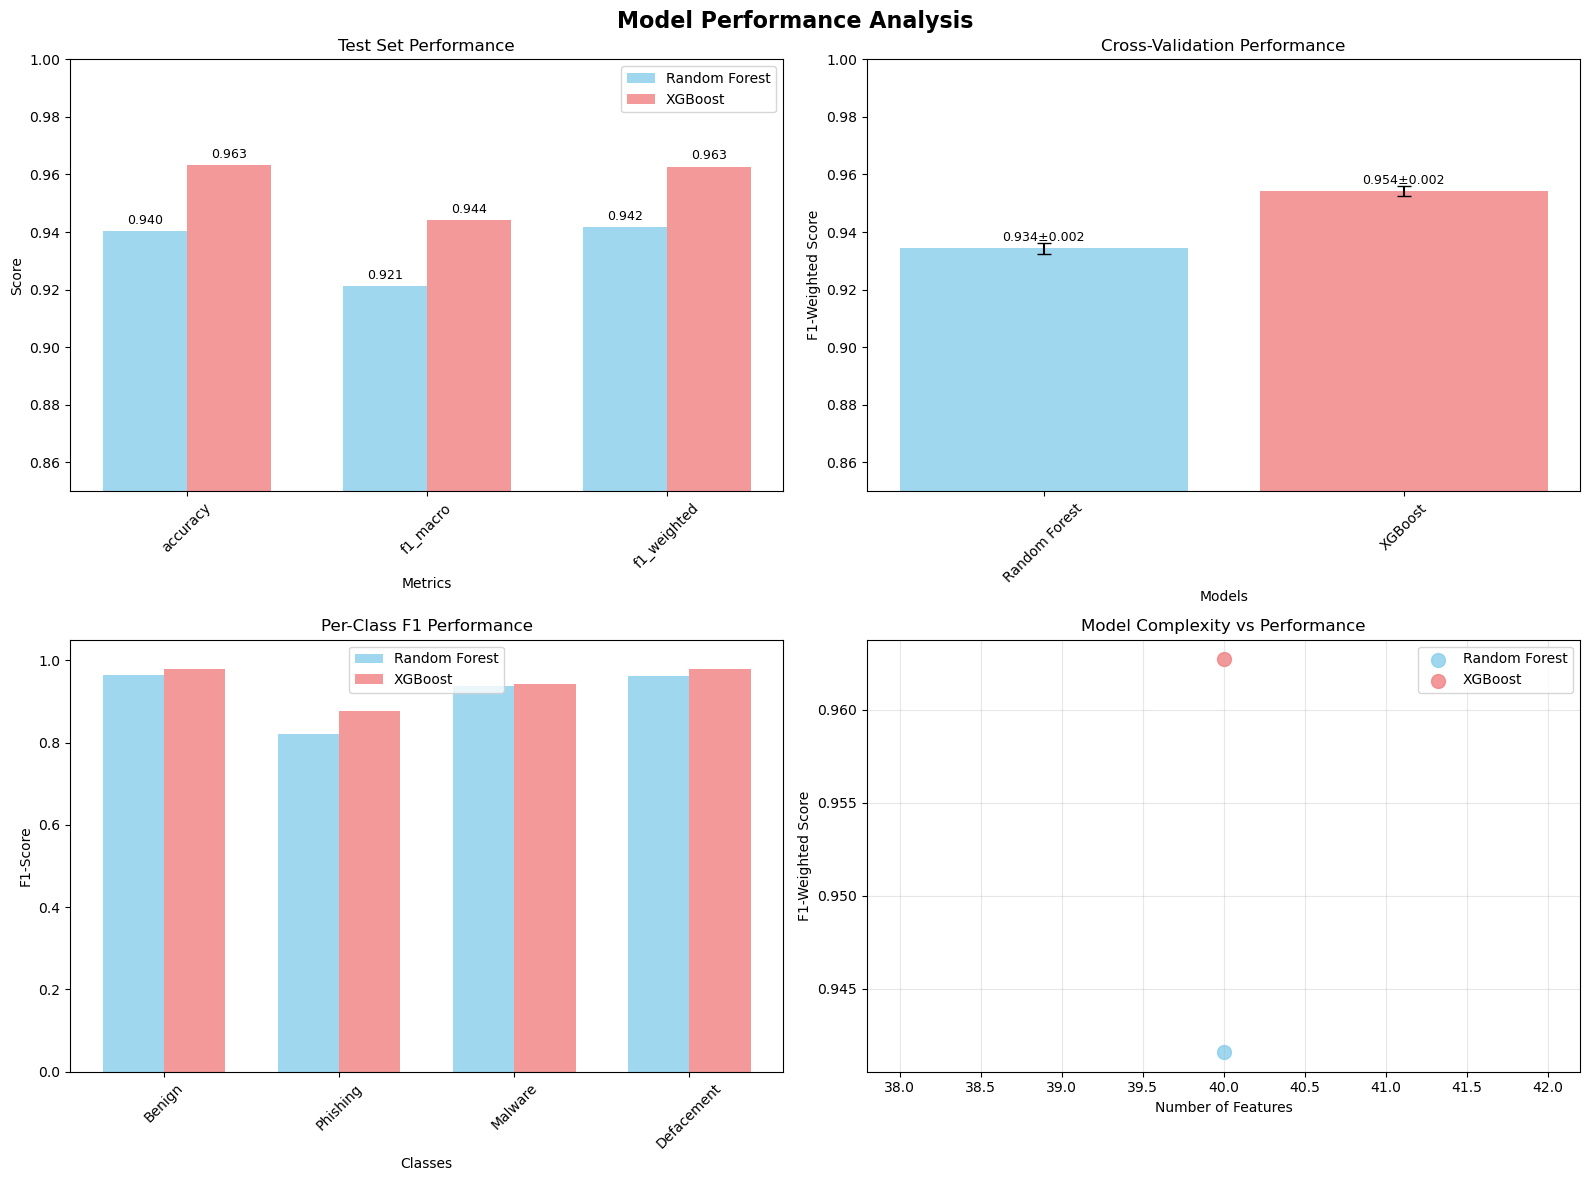

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# test set comparison (top left)
metrics = ['accuracy', 'f1_macro', 'f1_weighted']
rf_scores = [results['Random Forest'][m] for m in metrics]
xgb_scores = [results['XGBoost'][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0,0].bar(x - width/2, rf_scores, width, label='Random Forest', alpha=0.8, color='skyblue')
bars2 = axes[0,0].bar(x + width/2, xgb_scores, width, label='XGBoost', alpha=0.8, color='lightcoral')

axes[0,0].set_xlabel('Metrics')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Test Set Performance')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(metrics, rotation=45)
axes[0,0].legend()
axes[0,0].set_ylim(0.85, 1.0)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0,0].annotate(f'{height:.3f}',
                          xy=(bar.get_x() + bar.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom', fontsize=9)

# CV results (top right)
cv_models = list(cv_results.keys())
cv_means = [cv_results[model]['f1_weighted'][0] for model in cv_models]
cv_stds = [cv_results[model]['f1_weighted'][1] for model in cv_models]

x_cv = np.arange(len(cv_models))
bars_cv = axes[0,1].bar(x_cv, cv_means, yerr=cv_stds, capsize=5, 
                        alpha=0.8, color=['skyblue', 'lightcoral'])

axes[0,1].set_xlabel('Models')
axes[0,1].set_ylabel('F1-Weighted Score')
axes[0,1].set_title('Cross-Validation Performance')
axes[0,1].set_xticks(x_cv)
axes[0,1].set_xticklabels(cv_models, rotation=45)
axes[0,1].set_ylim(0.85, 1.0)

for i, (bar, mean, std) in enumerate(zip(bars_cv, cv_means, cv_stds)):
    axes[0,1].annotate(f'{mean:.3f}±{std:.3f}',
                      xy=(bar.get_x() + bar.get_width() / 2, mean),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=9)

# per-class (bottom left)
# Calculate per-class F1 scores from classification report
from sklearn.metrics import f1_score

class_names = ['Benign', 'Phishing', 'Malware', 'Defacement']
rf_class_f1 = f1_score(y_test, rf_pred, average=None)
xgb_class_f1 = f1_score(y_test, xgb_pred, average=None)

x_classes = np.arange(len(class_names))
width = 0.35

axes[1,0].bar(x_classes - width/2, rf_class_f1, width, label='Random Forest', 
              alpha=0.8, color='skyblue')
axes[1,0].bar(x_classes + width/2, xgb_class_f1, width, label='XGBoost', 
              alpha=0.8, color='lightcoral')

axes[1,0].set_xlabel('Classes')
axes[1,0].set_ylabel('F1-Score')
axes[1,0].set_title('Per-Class F1 Performance')
axes[1,0].set_xticks(x_classes)
axes[1,0].set_xticklabels(class_names, rotation=45)
axes[1,0].legend()
axes[1,0].set_ylim(0, 1.05)

# Model complexity vs performance (bottom right)
# no. of features against performance 
model_complexity = {
    'Random Forest': len(X.columns),
    'XGBoost': len(X.columns)
}

model_performance = {
    'Random Forest': results['Random Forest']['f1_weighted'],
    'XGBoost': results['XGBoost']['f1_weighted']
}

axes[1,1].scatter([model_complexity['Random Forest']], 
                 [model_performance['Random Forest']], 
                 s=100, alpha=0.8, color='skyblue', label='Random Forest')
axes[1,1].scatter([model_complexity['XGBoost']], 
                 [model_performance['XGBoost']], 
                 s=100, alpha=0.8, color='lightcoral', label='XGBoost')

axes[1,1].set_xlabel('Number of Features')
axes[1,1].set_ylabel('F1-Weighted Score')
axes[1,1].set_title('Model Complexity vs Performance')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance Summary Table

In [93]:
comparison_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'Test Accuracy': [results['Random Forest']['accuracy'], 
                     results['XGBoost']['accuracy']],
    'Test F1-Macro': [results['Random Forest']['f1_macro'], 
                     results['XGBoost']['f1_macro']],
    'Test F1-Weighted': [results['Random Forest']['f1_weighted'], 
                        results['XGBoost']['f1_weighted']],
    'CV F1-Weighted': [f"{cv_results['Random Forest']['f1_weighted'][0]:.4f} ± {cv_results['Random Forest']['f1_weighted'][1]:.4f}",
                       f"{cv_results['XGBoost']['f1_weighted'][0]:.4f} ± {cv_results['XGBoost']['f1_weighted'][1]:.4f}"],
    'ROC-AUC': [results['Random Forest']['roc_auc'], 
               results['XGBoost']['roc_auc']]
}

In [94]:
comparison_df = pd.DataFrame(comparison_data)

In [96]:
print(comparison_df.to_string(index=False, float_format='%.4f'))

        Model  Test Accuracy  Test F1-Macro  Test F1-Weighted  CV F1-Weighted  ROC-AUC
Random Forest         0.9403         0.9213            0.9416 0.9343 ± 0.0020   0.9905
      XGBoost         0.9634         0.9442            0.9627 0.9543 ± 0.0017   0.9939
